Welcome! This is my project called -> Predicting Ultra-Marathon Performance, Data Driven Approach using Specific Marathon Event trends and Athlete metadata

In [1]:
# Importing all necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
# The dataset is assumed to be in the same directory as this script
df = pd.read_csv("TWO_CENTURIES_OF_UM_RACES.csv")

C:\Users\Bryan Lee\AppData\Local\Temp\ipykernel_16912\3841928751.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TWO_CENTURIES_OF_UM_RACES.csv")


In [3]:
# Since it contains 7,461,226 ultra-marathon race records from 1,641,168 athletes, we will just sample a bit
df_sample = df.sample(frac=0.10, random_state=42)  # 10% sample

In [4]:
# Fixing the column types
# Convert dates and extract features
df_sample['Event dates'] = pd.to_datetime(df_sample['Event dates'], errors='coerce')
df_sample['Event_year'] = df_sample['Event dates'].dt.year
df_sample['Event_season'] = df_sample['Event dates'].dt.quarter  # 1=Winter, 2=Spring, etc.


In [5]:
#Clean up null values for data validity
df_sample.isnull().sum()
df_sample = df_sample.dropna()

In [6]:
df_sample.reset_index(drop=True)
df_sample.shape

(122366, 15)

In [7]:
df_sample['Athlete performance'] = df_sample['Athlete performance'].str.split(' ').str.get(0)

In [8]:
df_sample = df_sample.drop(['Athlete club'], axis = 1)

In [9]:
df_sample.reset_index(drop=True)
df.dtypes

Year of event                  int64
Event dates                   object
Event name                    object
Event distance/length         object
Event number of finishers      int64
Athlete performance           object
Athlete club                  object
Athlete country               object
Athlete year of birth        float64
Athlete gender                object
Athlete age category          object
Athlete average speed         object
Athlete ID                     int64
dtype: object

In [10]:
# Check for missing values in each column
print(df_sample.isna().sum())

Year of event                0
Event dates                  0
Event name                   0
Event distance/length        0
Event number of finishers    0
Athlete performance          0
Athlete country              0
Athlete year of birth        0
Athlete gender               0
Athlete age category         0
Athlete average speed        0
Athlete ID                   0
Event_year                   0
Event_season                 0
dtype: int64


In [11]:
# Standardizing the athlete performance to total seconds
df_sample['Athlete performance'] = pd.to_timedelta(df_sample['Athlete performance'].str.replace(' h', ''), errors='coerce').dt.total_seconds()

In [12]:
df_sample.shape

(122366, 14)

In [13]:
df_sample = df_sample[df_sample['Event distance/length'].isin(['50km', '100km'])]

In [14]:
# Extract numeric distance from the string and convert to float
df_sample['Event distance/length'] = df_sample['Event distance/length'].str.replace('km', '').astype(float)

In [15]:
df_sample['Athlete average speed'] = pd.to_numeric(df_sample['Athlete average speed'], errors='coerce')

In [16]:
df_sample.isnull().sum()
df_sample = df_sample.dropna(subset = ['Athlete average speed'])

In [17]:
# Calculate athlete's age at the event
df_sample['Athlete age'] = df_sample['Year of event'] - df_sample['Athlete year of birth']

In [18]:
# Extract country from event name
df_sample['Event country'] = df_sample['Event name'].str.extract(r'\((.*?)\)')

In [19]:
df_sample.head(10)

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID,Event_year,Event_season,Athlete age,Event country
1043395,2016,2016-09-10,Glacial Trail 50 km Race (USA),50.0,127,17799.0,USA,1975.0,M,M40,10.113,480555,2016.0,3.0,41.0,USA
2050427,2019,2019-12-05,Ebisu-Daikoku 100 km Marathon (JPN),100.0,451,41226.0,JPN,1985.0,M,M23,8.732,182462,2019.0,4.0,34.0,JPN
545227,2018,2018-06-10,Baker Lake 50K Ultra Trail Run (USA),50.0,145,15599.0,USA,1988.0,M,M23,11.539,12077,2018.0,2.0,30.0,USA
3163494,2022,2022-05-02,Fort Ord 50K Trail Run (USA),50.0,65,19766.0,USA,1978.0,M,M40,9.107,378461,2022.0,2.0,44.0,USA
6362442,2015,2015-04-04,Two Oceans Marathon - 50km Split (RSA),50.0,8587,17161.0,RSA,1978.0,F,W35,10.489,137405,2015.0,2.0,37.0,RSA
2203585,2019,2019-02-06,Nanto 100 Km Ultramarathon (JPN),100.0,328,48693.0,JPN,1974.0,F,W40,7.393,263050,2019.0,1.0,45.0,JPN
3297465,2022,2022-07-05,Grayson Highlands 50km Race (USA),50.0,187,24420.0,USA,1961.0,M,M60,7.371,597384,2022.0,3.0,61.0,USA
2433497,2019,2019-12-10,Oil Creek 50 km Trail Run (USA),50.0,181,23538.0,USA,1988.0,M,M23,7.647,207793,2019.0,4.0,31.0,USA
2099602,2019,2019-06-07,thüringenULTRA 100 km (GER),100.0,227,39050.0,GER,1960.0,M,M55,9.219,187174,2019.0,2.0,59.0,GER
1022972,2016,2016-09-07,Mt. Hood 50 Km Trail Run (USA),50.0,137,24389.0,USA,1973.0,F,W40,7.380,491266,2016.0,3.0,43.0,USA


In [20]:
# Check for duplicates
print(df_sample.duplicated().sum())

# Drop duplicates
df_sample = df_sample.drop_duplicates()

0


In [21]:
# Final checking of the data types
print(df_sample.dtypes)
df_sample.shape

Year of event                         int64
Event dates                  datetime64[ns]
Event name                           object
Event distance/length               float64
Event number of finishers             int64
Athlete performance                 float64
Athlete country                      object
Athlete year of birth               float64
Athlete gender                       object
Athlete age category                 object
Athlete average speed               float64
Athlete ID                            int64
Event_year                          float64
Event_season                        float64
Athlete age                         float64
Event country                        object
dtype: object


(41178, 16)

In [22]:
# Just for representation, since we have two categories of races, 50km and 100km, we can view the statistics of each categories by seperating them first
df_50km = df_sample[df_sample['Event distance/length'] == 50]
df_100km = df_sample[df_sample['Event distance/length'] == 100]

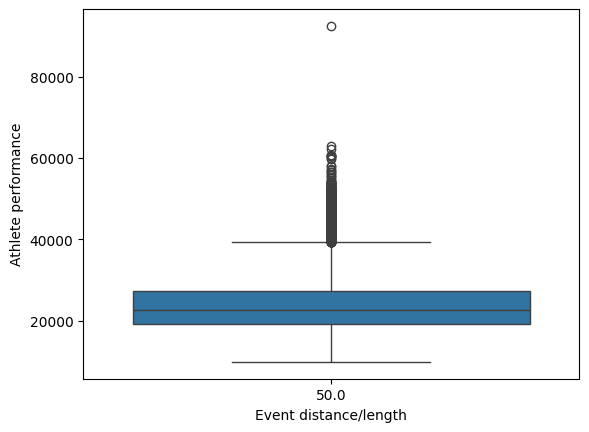

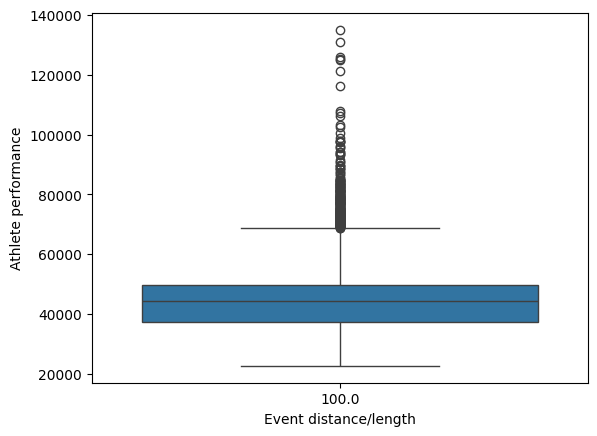

count    33000.000000
mean     23664.249091
std       6371.372887
min       9849.000000
25%      19158.000000
50%      22718.000000
75%      27212.000000
max      92467.000000
Name: Athlete performance, dtype: float64

In [23]:
sns.boxplot(x='Event distance/length', y='Athlete performance', data=df_50km)
plt.show()
sns.boxplot(x='Event distance/length', y='Athlete performance', data=df_100km)
plt.show()

df_50km['Athlete performance'].describe()

In [24]:
# As there are outliers, we want to clean up the data first before continuing, we will clean up each category first, and then merge the dataset back together in order to prepare the final dataset for the model. We are focusing primarily on athlete performance

# First we want to clean the 50km dataset first
# Calculate Q1 (25th percentile) and Q3 (75th percentile)

Q1_50 = df_50km['Athlete performance'].quantile(0.25)
Q3_50 = df_50km['Athlete performance'].quantile(0.75)

# Calculate the IQR
IQR_50 = Q3_50 - Q1_50

# Define lower and upper bounds
lower_bound_50 = Q1_50 - 1.5 * IQR_50
upper_bound_50 = Q3_50 + 1.5 * IQR_50

print(f"Lower Bound (50km): {lower_bound_50}, Upper Bound (50km): {upper_bound_50}")



Lower Bound (50km): 7077.0, Upper Bound (50km): 39293.0


In [25]:
# Next we want to calculate the statitics for the 100km races
# Calculate Q1 (25th percentile) and Q3 (75th percentile)

Q1_100 = df_100km['Athlete performance'].quantile(0.25)
Q3_100 = df_100km['Athlete performance'].quantile(0.75)

# Calculate the IQR
IQR_100 = Q3_100 - Q1_100

# Define lower and upper bounds
lower_bound_100 = Q1_100 - 1.5 * IQR_100
upper_bound_100 = Q3_100 + 1.5 * IQR_100

print(f"Lower Bound (100km): {lower_bound_100}, Upper Bound (100km): {upper_bound_100}")



Lower Bound (100km): 18234.75, Upper Bound (100km): 68872.75


In [26]:
# If we remove the outliers based on the IQR rule, it will significantly reduce the dataset, thus we will take Winsorize the outliers , capping the outliers at the 2nd and 98th percentiles
# Cap outliers at the 2nd and 98th percentiles
lower_cap_50 = df_50km['Athlete performance'].quantile(0.02)
upper_cap_50 = df_50km['Athlete performance'].quantile(0.98)

df_50km['Athlete performance'] = df_50km['Athlete performance'].clip(lower=lower_cap_50, upper=upper_cap_50)

C:\Users\Bryan Lee\AppData\Local\Temp\ipykernel_16912\2067691533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50km['Athlete performance'] = df_50km['Athlete performance'].clip(lower=lower_cap_50, upper=upper_cap_50)


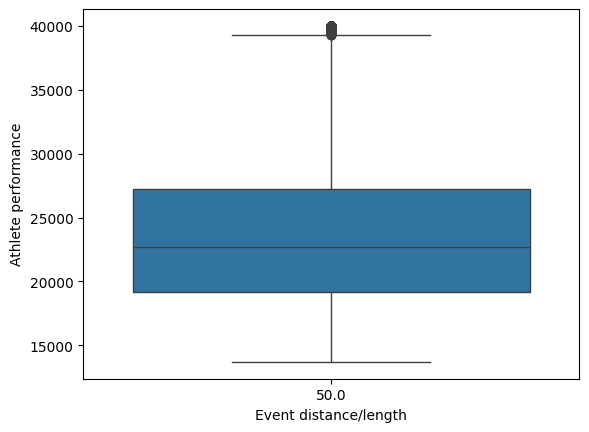

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID,Event_year,Event_season,Athlete age,Event country
1043395,2016,2016-09-10,Glacial Trail 50 km Race (USA),50.0,127,17799.0,USA,1975.0,M,M40,10.113,480555,2016.0,3.0,41.0,USA
545227,2018,2018-06-10,Baker Lake 50K Ultra Trail Run (USA),50.0,145,15599.0,USA,1988.0,M,M23,11.539,12077,2018.0,2.0,30.0,USA
3163494,2022,2022-05-02,Fort Ord 50K Trail Run (USA),50.0,65,19766.0,USA,1978.0,M,M40,9.107,378461,2022.0,2.0,44.0,USA
6362442,2015,2015-04-04,Two Oceans Marathon - 50km Split (RSA),50.0,8587,17161.0,RSA,1978.0,F,W35,10.489,137405,2015.0,2.0,37.0,RSA
3297465,2022,2022-07-05,Grayson Highlands 50km Race (USA),50.0,187,24420.0,USA,1961.0,M,M60,7.371,597384,2022.0,3.0,61.0,USA
2433497,2019,2019-12-10,Oil Creek 50 km Trail Run (USA),50.0,181,23538.0,USA,1988.0,M,M23,7.647,207793,2019.0,4.0,31.0,USA
1022972,2016,2016-09-07,Mt. Hood 50 Km Trail Run (USA),50.0,137,24389.0,USA,1973.0,F,W40,7.380,491266,2016.0,3.0,43.0,USA
5283817,2012,2012-04-02,Orcas Island 50k (USA),50.0,171,33161.0,USA,1976.0,M,M35,5.428,1236879,2012.0,2.0,36.0,USA
5215682,2011,2011-05-11,Bootlegger 50K (USA),50.0,44,19957.0,USA,1967.0,M,M40,9.019,516977,2011.0,2.0,44.0,USA
3044754,2021,2021-02-10,Iron Bull 50km Ultra Race (USA),50.0,43,39016.0,USA,1971.0,M,M45,4.613,916821,2021.0,1.0,50.0,USA


In [27]:
sns.boxplot(x='Event distance/length', y='Athlete performance', data=df_50km)
plt.show()
df_50km.head(10)

In [28]:
# If we remove the outliers based on the IQR rule, it will significantly reduce the dataset, thus we will take Winsorize the outliers , capping the outliers at the 2nd and 98th percentiles
# Cap outliers at the 2nd and 98th percentiles
lower_cap_100 = df_100km['Athlete performance'].quantile(0.02)
upper_cap_100 = df_100km['Athlete performance'].quantile(0.98)

df_100km['Athlete performance'] = df_100km['Athlete performance'].clip(lower=lower_cap_100, upper=upper_cap_100)

C:\Users\Bryan Lee\AppData\Local\Temp\ipykernel_16912\3126951042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100km['Athlete performance'] = df_100km['Athlete performance'].clip(lower=lower_cap_100, upper=upper_cap_100)


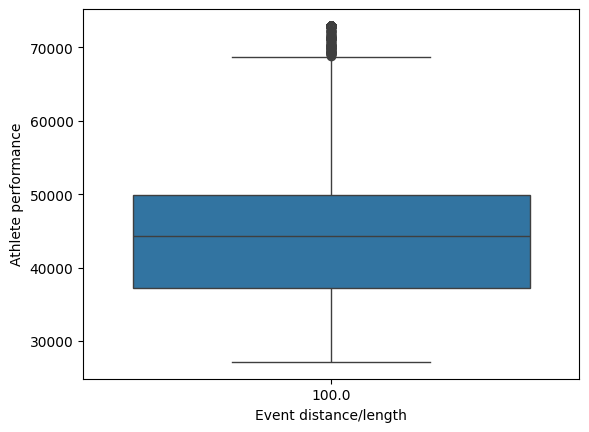

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID,Event_year,Event_season,Athlete age,Event country
2050427,2019,2019-12-05,Ebisu-Daikoku 100 km Marathon (JPN),100.0,451,41226.0,JPN,1985.0,M,M23,8.732,182462,2019.0,4.0,34.0,JPN
2203585,2019,2019-02-06,Nanto 100 Km Ultramarathon (JPN),100.0,328,48693.0,JPN,1974.0,F,W40,7.393,263050,2019.0,1.0,45.0,JPN
2099602,2019,2019-06-07,thüringenULTRA 100 km (GER),100.0,227,39050.0,GER,1960.0,M,M55,9.219,187174,2019.0,2.0,59.0,GER
5144395,2011,2011-12-06,Iwate Ginga 100km Marathon Challenge (JPN),100.0,597,37325.0,JPN,1959.0,M,M50,9.645,446156,2011.0,4.0,52.0,JPN
1337474,2017,2017-05-03,Nagoura Marathon 100 Km (JPN),100.0,234,41590.0,JPN,1963.0,M,M50,8.656,80261,2017.0,2.0,54.0,JPN
2578168,2020,2020-11-07,Beaverhead 100K Endurance Run (USA),100.0,108,40124.0,USA,1987.0,M,M23,8.972,479949,2020.0,4.0,33.0,USA
311127,2018,2018-12-05,Quicksilver 100 km Endurance Run (USA),100.0,166,51728.0,USA,1965.0,M,M50,6.959,117585,2018.0,4.0,53.0,USA
6511081,2015,2015-09-05,Quicksilver 100 km Endurance Run (USA),100.0,181,47612.0,USA,1965.0,M,M45,7.561,67498,2015.0,3.0,50.0,USA
3670140,1997,1997-05-07,100 km de Mulhouse - open race (FRA),100.0,237,36089.0,FRA,1955.0,F,W40,9.975,1073601,1997.0,2.0,42.0,FRA
7184911,1989,1989-02-09,100 km Lauf Unna (GER),100.0,305,38092.0,GER,1938.0,M,M50,9451.000,1047276,1989.0,1.0,51.0,GER


In [29]:
sns.boxplot(x='Event distance/length', y='Athlete performance', data=df_100km)
plt.show()
df_100km.head(10)

In [30]:
# After data cleaning, we will concatenate the two datasets back together
final_df = pd.concat([df_50km, df_100km], axis=0, ignore_index=True)

In [31]:
# We will drop unrelated columns that are not needed for the model
final_df = final_df.drop(['Year of event', 'Event dates', 'Athlete year of birth', 'Athlete average speed', 'Athlete ID'], axis=1)

In [32]:
final_df.head(10)

,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete country,Athlete gender,Athlete age category,Event_year,Event_season,Athlete age,Event country
0,Glacial Trail 50 km Race (USA),50.0,127,17799.0,USA,M,M40,2016.0,3.0,41.0,USA
1,Baker Lake 50K Ultra Trail Run (USA),50.0,145,15599.0,USA,M,M23,2018.0,2.0,30.0,USA
2,Fort Ord 50K Trail Run (USA),50.0,65,19766.0,USA,M,M40,2022.0,2.0,44.0,USA
3,Two Oceans Marathon - 50km Split (RSA),50.0,8587,17161.0,RSA,F,W35,2015.0,2.0,37.0,RSA
4,Grayson Highlands 50km Race (USA),50.0,187,24420.0,USA,M,M60,2022.0,3.0,61.0,USA
5,Oil Creek 50 km Trail Run (USA),50.0,181,23538.0,USA,M,M23,2019.0,4.0,31.0,USA
6,Mt. Hood 50 Km Trail Run (USA),50.0,137,24389.0,USA,F,W40,2016.0,3.0,43.0,USA
7,Orcas Island 50k (USA),50.0,171,33161.0,USA,M,M35,2012.0,2.0,36.0,USA
8,Bootlegger 50K (USA),50.0,44,19957.0,USA,M,M40,2011.0,2.0,44.0,USA
9,Iron Bull 50km Ultra Race (USA),50.0,43,39016.0,USA,M,M45,2021.0,1.0,50.0,USA


In [33]:
final_df = final_df.drop(['Event number of finishers', 'Athlete country', 'Athlete country', 'Athlete age category','Event_year'], axis = 1)

In [34]:
final_df.head(10)
final_df['Event name'] = final_df['Event name'].str.split('(').str.get(0)

In [35]:
final_df.head(10)

,Event name,Event distance/length,Athlete performance,Athlete gender,Event_season,Athlete age,Event country
0,Glacial Trail 50 km Race,50.0,17799.0,M,3.0,41.0,USA
1,Baker Lake 50K Ultra Trail Run,50.0,15599.0,M,2.0,30.0,USA
2,Fort Ord 50K Trail Run,50.0,19766.0,M,2.0,44.0,USA
3,Two Oceans Marathon - 50km Split,50.0,17161.0,F,2.0,37.0,RSA
4,Grayson Highlands 50km Race,50.0,24420.0,M,3.0,61.0,USA
5,Oil Creek 50 km Trail Run,50.0,23538.0,M,4.0,31.0,USA
6,Mt. Hood 50 Km Trail Run,50.0,24389.0,F,3.0,43.0,USA
7,Orcas Island 50k,50.0,33161.0,M,2.0,36.0,USA
8,Bootlegger 50K,50.0,19957.0,M,2.0,44.0,USA
9,Iron Bull 50km Ultra Race,50.0,39016.0,M,1.0,50.0,USA


In [36]:
# Beginning the ML model Traning
# Idea -> By inputting the Athlete age and gender, Event name, Event distance, and Event season, we are able to predict the Athlete's performance
# Constrains, models are only predicting in races Kilometer race cetegories

In [37]:
# First, we do feature engineering through target encoding
# Calculate the average performance for each event
event_performance_mean = final_df.groupby('Event name')['Athlete performance'].mean()

In [38]:
# Replace the event name with its mean performance
final_df['Event name (encoded)'] = final_df['Event name'].map(event_performance_mean)
final_df.head(10)
final_df = final_df.drop(['Event country'], axis=1)


In [ ]:
# # To prevent information leakage, split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the dataset into training and test sets
X = final_df.drop(columns=['Athlete performance'])
y = final_df['Athlete performance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate target encoding based on training data
event_performance_mean = X_train.merge(y_train, left_index=True, right_index=True).groupby('Event name')['Athlete performance'].mean()

X_train['Event name (encoded)'] = X_train['Event name'].map(event_performance_mean)
X_test['Event name (encoded)'] = X_test['Event name'].map(event_performance_mean)

# Handle unseen events in the test set (fallback to global mean if the input event was not included in the original dataset) 
global_mean = y_train.mean()
X_test['Event name (encoded)'] = X_test['Event name (encoded)'].fillna(global_mean)

X_train = X_train.drop(columns=['Event name'])
X_test = X_test.drop(columns=['Event name'])

label_encoder = LabelEncoder()
X_train['Athlete gender'] = label_encoder.fit_transform(X_train['Athlete gender'])
X_test['Athlete gender'] = label_encoder.transform(X_test['Athlete gender'])

final_df = final_df.drop(columns=['Event name'])


In [40]:
# Since the values of athlete performance are continuous data, then we will use a simple Random Forest Regressor

# Initialize the model
model = RandomForestRegressor(random_state=42)
# Train the model on the training set
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 3914.627208307968
Mean Squared Error (MSE): 28004016.05111189
R² Score: 0.7739181513970181


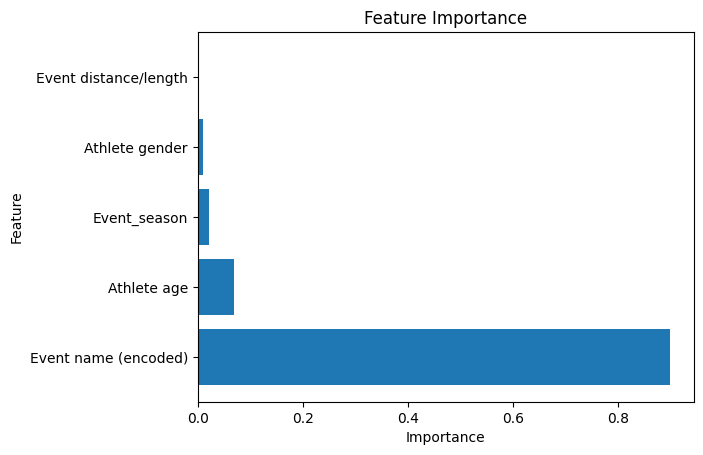

In [49]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# import joblib
# joblib.dump(model, 'athlete_performance_model.pkl')
# loaded_model = joblib.load('athlete_performance_model.pkl')

In [ ]:
# Example user input
user_input = {
    'Event name': 'Flatland Marathon',
    'Event distance/length': 50,
    'Event season': 2,
    'Athlete age': 30,
    'Athlete gender': 'M'
}

# Preprocess the user input
user_input_encoded = user_input.copy()
user_input_encoded['Event name (encoded)'] = event_performance_mean.get(
    user_input['Event name'], global_mean 
)
user_input_encoded.pop('Event name')
user_input_encoded['Athlete gender'] = label_encoder.transform([user_input['Athlete gender']])[0]
user_input_df = pd.DataFrame([user_input_encoded])
user_input_df = user_input_df.reindex(columns=X_train.columns, fill_value=0)


user_prediction = model.predict(user_input_df)
print(f"Predicted Athlete Performance: {user_prediction[0]}")

Predicted Athlete Performance: 24055.8415
